# Apprentissage statistique

## Sequential neural networks

## Octave Mariotti

In [2]:
#%matplotlib notebook
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim

import numpy as np
import matplotlib.pyplot as plt

In [3]:
class selector(nn.Module):
    """
    selector module will apply a linear
    transfor and output a probability
    distribution among n_choices choices
    """
    def __init__(self, input_size, n_choices=2):
        super(selector, self).__init__()
        self.input_size = input_size
        self.n_choices = n_choices
        self.lin = nn.Linear(input_size, n_choices)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x):
        return self.softmax(self.lin(x))
    
    def pweight(self):
        print(self.lin.weight)

In [4]:
class leaf_lin(nn.Module):
    """
    Leaf linear module contains
    two linear modules, and acts as
    one of the two depending on 
    input value h
    """
    def __init__(self, input_size, output_size):
        super(leaf_lin, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.lin1 = nn.Linear(input_size, output_size)
        self.lin2 = nn.Linear(input_size, output_size)
        
    def forward(self, x, h):
        return torch.sigmoid(h * self.lin1(x) + (1-h) * self.lin2(x))

In [5]:
class linear(nn.Module):
    def __init__(self, input_size, output_size):
        super(linear, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.W1 = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        return torch.tanh(self.W1(x))        

In [6]:
def binarize(target, nb_classes, neg_value=0):
    """
    encode target en one-hot, si neg_value 
    vaut zéro, ou en -1/1, si neg_value vaut
    -1 par exemple
    """
    target = target.long()
    tar_shape = target.shape
    y_onehot = torch.FloatTensor(*tar_shape, nb_classes)
    y_onehot.zero_().add_(neg_value)
    return y_onehot.scatter_(len(tar_shape), target.view(*tar_shape, 1), 1)



On utilise comme données d'entraînement quatre distribution gaussiennes placées en opposition les unes des autres. Ainsi, un modèle linéaire ne pourra les séparer, et il faudra

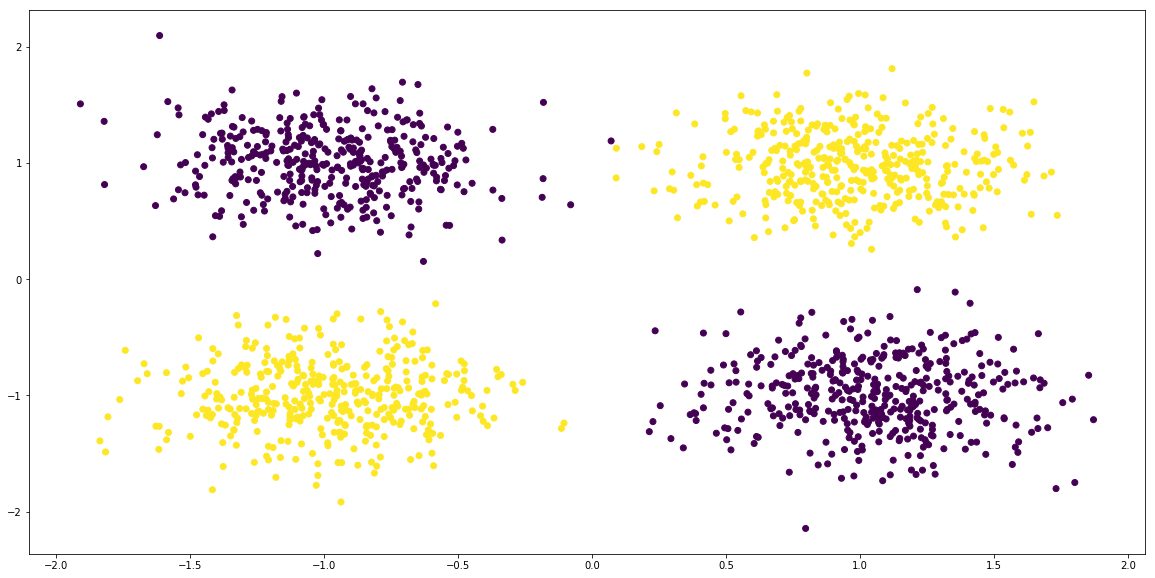

In [37]:
batch_size = 1
input_dim = 2
output_dim = 2
data_size = 1600


data = torch.Tensor(data_size, 2).uniform_(-1,1).sign() 
train = data + torch.Tensor(data_size, 2).normal_(std=.3)
target = torch.sign(data[:,0]*data[:,1]).unsqueeze(1)

plt.clf()
plt.scatter(train[:,0].numpy(), train[:,1].numpy(), c=target.squeeze().numpy())
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch  0
Train loss  0.3678301239013672
Entropy  0.5124950790405274
Epoch  1
Train loss  0.23874521255493164
Entropy  0.4936552047729492
Epoch  2
Train loss  0.21075822830200194
Entropy  0.4776255035400391
Epoch  3
Train loss  0.15814910888671874
Entropy  0.4636006546020508
Epoch  4
Train loss  0.1579074764251709
Entropy  0.4507840347290039
Epoch  5
Train loss  0.14732102394104005
Entropy  0.4391202926635742
Epoch  6
Train loss  0.1389387607574463
Entropy  0.4272780990600586
Epoch  7
Train loss  0.1140267276763916
Entropy  0.4171901321411133
Epoch  8
Train loss  0.11110595703125
Entropy  0.40865966796875
Epoch  9
Train loss  0.10207950592041015
Entropy  0.4008787536621094
Epoch  10
Train loss  0.10563285827636719
Entropy  0.39266506195068357
Epoch  11
Train loss  0.07810457706451417
Entropy  0.3859937286376953
Epoch  12
Train loss  0.07856419086456298
Entropy  0.380474739074707
Epoch  13
Train loss  0.06467866420745849
Entropy  0.37562553405761717
Epoch  14
Train loss  0.06598134994506

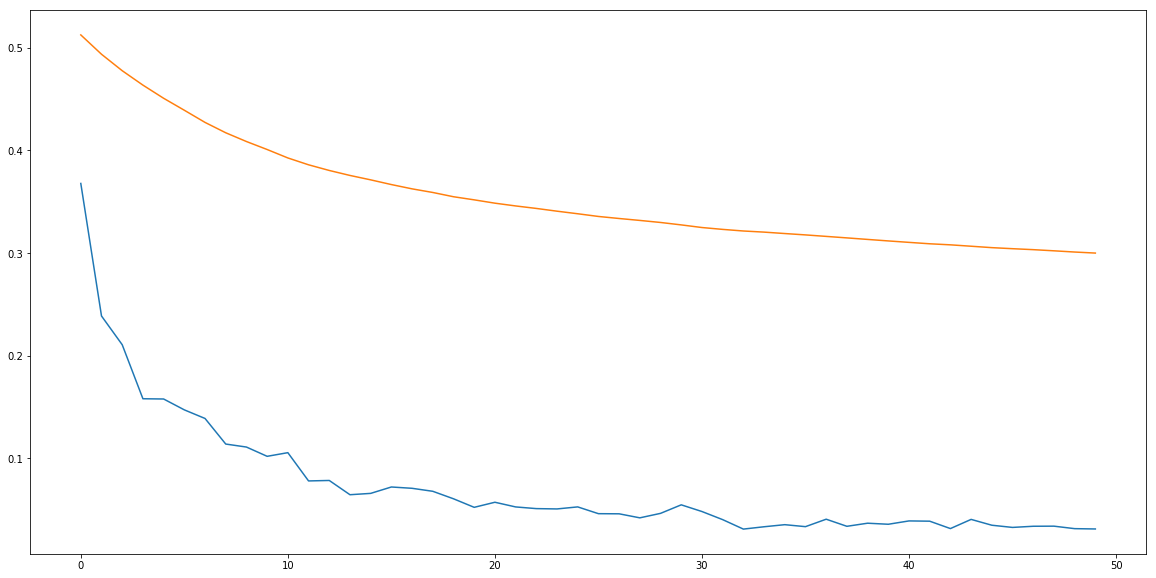

In [46]:
print_every = 25
n_epochs = 50
gradient_step = 0.01
model1 = linear(input_dim, output_dim)
mF = selector(input_dim)
mG = leaf_lin(input_dim, output_dim)

optimizerF = optim.SGD(mF.parameters(), lr=gradient_step*0.1)
optimizerG = optim.Adam(mG.parameters(), lr=gradient_step)

hist_loss = []
hist_ent = []

for k in range(n_epochs):
    
    entropy = 0
    g_loss = 0
    
    for i in range(len(data)):
        optimizerF.zero_grad()
        optimizerG.zero_grad()
        x = Variable(train[i])
        y = Variable(binarize(target[i]+1/2, output_dim).squeeze())
        outF = mF(x)
        h = torch.multinomial(outF.exp())
        #on casse le graphe de calcul
        h2 = Variable(h.data.float(), requires_grad=False)
        outG = mG(x, h2)
        loss = (outG - y)*(outG - y)
        #On utilise le résultat pour estimer une loss sur le module de sélection 
        reward =  outF * Variable(loss.data, requires_grad=False) - loss.data.mean()
        loss.mean().backward()
        reward.mean().backward()
        g_loss += loss.sum()
        entropy -= (outF.exp()*outF).sum()
        optimizerF.step()
        optimizerG.step()
        
    print("Epoch ", k)
    print("Train loss ", g_loss.data[0]/data_size)
    print("Entropy ", entropy.data[0]/data_size)
    hist_loss.append(g_loss.data[0]/data_size)
    hist_ent.append(entropy.data[0]/data_size)

plt.clf()
plt.plot(hist_loss)
plt.plot(hist_ent)
plt.show()

On peut tracer la frontière de décision du modèle, en effectuant des tirages aléatoires. Cela éventuelement permet de localiser les zones où le sélecteur risque de guider le modèle dans la mauvaise branche de l'arbre.

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


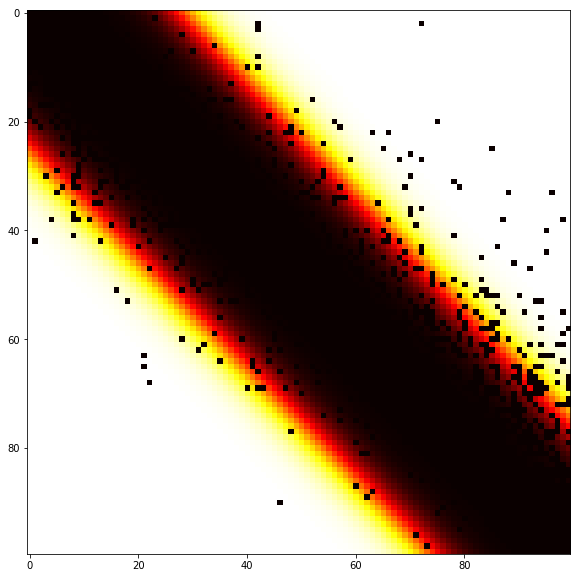

In [47]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
coords = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

mat = torch.from_numpy(coords).float()

zones = []

for coord in mat:
    x = Variable(coord)
    outF = mF(x)
    h = torch.multinomial(outF.exp())
    h2 = Variable(h.data.float(), requires_grad=False)
    outG = mG(x, h2)
    zones.append(outG.data)

classes = [z[0]-z[1] for z in zones]

hm = np.array(classes).reshape(100,100)

plt.clf()
plt.imshow(hm, cmap='hot', interpolation='nearest')
plt.show()

<IPython.core.display.Javascript object>


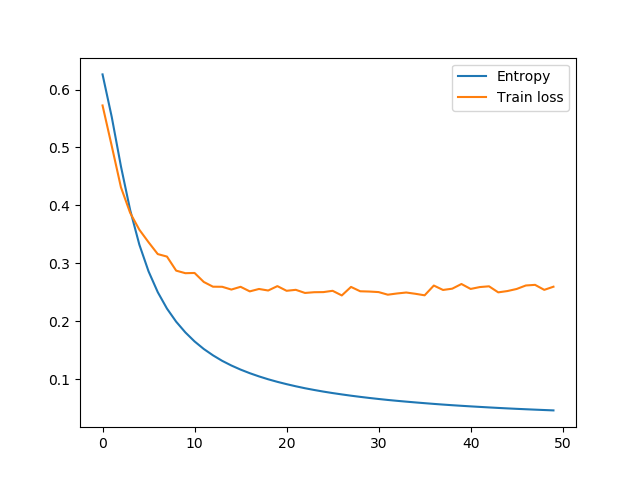

In [369]:
plt.clf()
plt.plot(hist_ent, label="Entropy")
plt.plot(hist_loss, label="Train loss")
plt.legend()
plt.show()

On observe bien une baisse de l'entropie de la sortie du module de sélection. Plus l'apprentissage progresse, plus ce dernier convergera vers un modèle déterministe.

La frontière de décision du modèle est aassez sensible aux données. Si les clusters sont trop ressérés, le modèle convergera la plupart du temps vers une bande oblique englobant deux clusters (figure stripes). Si ils se recouvrent, il préférera une configuration 'en damier', avec la frontière de décision du sélecteru perpendiculaire à celles des modules linéaires (figure checkers).

La préférence pour un modèle 'en bande' peut être due à une minimisation du risque au niveau du sélecteur : peu importe son choix, un exemple proche de la frontière de décision sera toujours classé de la même manière, ce qui n'est pas le cas du moèle en damier. Il s'agit donc d'un minimum local sous-optimal.